In [436]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [437]:
df = pd.read_csv('data/training.csv')

In [438]:
df.head()

,motion_state,axdt_sum,aydt_sum,azdt_sum,gxdt_sum,gydt_sum,gzdt_sum,adt_sum,gdt_sum,axdt_var,...,adt_min,gdt_min,axdt_max,aydt_max,azdt_max,gxdt_max,gydt_max,gzdt_max,adt_max,gdt_max
0,straight,0.208844,0.078495,9.493337,-0.001675,0.001102,-0.001176,9.498792,0.008515,0.000004,...,0.093785,0.000026,0.005700,0.002976,0.101778,0.000119,0.000115,0.000103,0.101785,0.000171
1,straight,0.211935,0.086485,9.794426,-0.001977,0.000370,-0.000462,9.799902,0.008413,0.000004,...,0.094010,0.000015,0.005566,0.002930,0.101622,0.000137,0.000131,0.000090,0.101634,0.000167
2,rest,0.214289,0.083671,9.786784,-0.001740,0.000793,-0.001662,9.792245,0.009893,0.000004,...,0.093513,0.000010,0.005701,0.002926,0.101971,0.000110,0.000191,0.000181,0.101982,0.000219
3,rest,0.218394,0.083838,9.791271,-0.002218,0.001297,-0.001483,9.796759,0.009319,0.000004,...,0.093461,0.000017,0.005728,0.002998,0.102332,0.000101,0.000179,0.000102,0.102362,0.000206
4,straight,0.222900,0.259758,9.795122,-0.000059,0.001148,-0.001739,9.806574,0.009778,0.000003,...,0.093818,0.000032,0.005978,0.010632,0.102123,0.000207,0.000126,0.000130,0.102166,0.000213


In [439]:
y = df['motion_state'].copy()


In [440]:
feature_cols = 'adt_sum,gdt_sum,axdt_var,aydt_var,azdt_var,gxdt_var,gydt_var,gzdt_var,adt_var,gdt_var,adt_min,gdt_min,adt_max,gdt_max'.split(',')
X = df[feature_cols].copy()
# X = df[[col for col in df.columns if col !='motion_state']].copy()

In [441]:
X.head()

,adt_sum,gdt_sum,axdt_var,aydt_var,azdt_var,gxdt_var,gydt_var,gzdt_var,adt_var,gdt_var,adt_min,gdt_min,adt_max,gdt_max
0,9.498792,0.008515,0.000004,0.000001,0.000006,3.856139e-09,2.467973e-09,1.958251e-09,0.000006,1.076465e-09,0.093785,0.000026,0.101785,0.000171
1,9.799902,0.008413,0.000004,0.000001,0.000007,3.463234e-09,2.769963e-09,1.785013e-09,0.000006,1.299795e-09,0.094010,0.000015,0.101634,0.000167
2,9.792245,0.009893,0.000004,0.000001,0.000007,3.881253e-09,3.281482e-09,3.870479e-09,0.000007,1.794662e-09,0.093513,0.000010,0.101982,0.000219
3,9.796759,0.009319,0.000004,0.000001,0.000008,3.439800e-09,3.309496e-09,2.681825e-09,0.000008,1.547565e-09,0.093461,0.000017,0.102362,0.000206
4,9.806574,0.009778,0.000003,0.000008,0.000006,5.623301e-09,2.478434e-09,2.738851e-09,0.000006,1.621392e-09,0.093818,0.000032,0.102166,0.000213


In [442]:
y.head()

0    straight
1    straight
2        rest
3        rest
4    straight
Name: motion_state, dtype: object

In [443]:
print(f"X is of type {type(X)} and size {X.shape}")
print(f"y is of type {type(y)} and size {y.shape}")

X is of type <class 'pandas.core.frame.DataFrame'> and size (259, 14)
y is of type <class 'pandas.core.series.Series'> and size (259,)


In [444]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   adt_sum   259 non-null    float64
 1   gdt_sum   259 non-null    float64
 2   axdt_var  259 non-null    float64
 3   aydt_var  259 non-null    float64
 4   azdt_var  259 non-null    float64
 5   gxdt_var  259 non-null    float64
 6   gydt_var  259 non-null    float64
 7   gzdt_var  259 non-null    float64
 8   adt_var   259 non-null    float64
 9   gdt_var   259 non-null    float64
 10  adt_min   259 non-null    float64
 11  gdt_min   259 non-null    float64
 12  adt_max   259 non-null    float64
 13  gdt_max   259 non-null    float64
dtypes: float64(14)
memory usage: 28.5 KB


In [445]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [446]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [447]:
param_grid = [
                {
                'classifier': [KNeighborsClassifier()],
                'preprocessing': [RobustScaler(), MinMaxScaler(), StandardScaler(), None],
                'classifier__n_neighbors': [2, 4, 6, 8, 12, 20],                
                }
]

In [448]:
pipe = Pipeline([('preprocessing',RobustScaler()), ('classifier',KNeighborsClassifier())])

In [449]:
grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', RobustScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid=[{'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [2, 4, 6, 8, 12, 20],
                          'preprocessing': [RobustScaler(), MinMaxScaler(),
                                            StandardScaler(), None]}],
             return_train_score=True)

In [450]:
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation train score: {:.2f}".format(grid.cv_results_['mean_train_score'][grid.best_index_]))
print("Best cross-validation validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': KNeighborsClassifier(), 'classifier__n_neighbors': 2, 'preprocessing': None}

Best cross-validation train score: 0.90
Best cross-validation validation score: 0.85
Test-set score: 0.86


In [451]:
df2 = pd.read_csv('data/testing.csv')

In [452]:
df2.head()

,motion_state,axdt_sum,aydt_sum,azdt_sum,gxdt_sum,gydt_sum,gzdt_sum,adt_sum,gdt_sum,axdt_var,...,adt_min,gdt_min,axdt_max,aydt_max,azdt_max,gxdt_max,gydt_max,gzdt_max,adt_max,gdt_max
0,rest,0.006394,0.081056,4.600224,-0.001271,0.000601,-0.001101,4.602953,0.004064,0.000006,...,0.093153,0.000020,0.003930,0.004634,0.102857,0.000082,0.000127,0.000083,0.102891,0.000189
1,rest,0.017316,0.176440,9.790282,-0.001097,0.001590,-0.001171,9.795434,0.008478,0.000005,...,0.093168,0.000013,0.003939,0.004913,0.102523,0.000145,0.000122,0.000154,0.102563,0.000162
2,straight,0.017127,0.176695,9.788586,-0.001558,0.000661,-0.000909,9.793045,0.008932,0.000004,...,0.093440,0.000033,0.003908,0.004152,0.102164,0.000162,0.000157,0.000116,0.102174,0.000179
3,straight,0.032500,0.482298,9.784766,-0.000104,0.000501,-0.002057,9.808845,0.009974,0.000004,...,0.092092,0.000014,0.004668,0.020014,0.102909,0.000229,0.000139,0.000106,0.103117,0.000243
4,turn,0.072554,1.216363,9.795191,0.001055,0.000061,-0.027254,9.880517,0.030474,0.000006,...,0.094830,0.000055,0.005518,0.019253,0.102949,0.000252,0.000201,-0.000023,0.103888,0.000521


In [453]:
y2 = df2['motion_state'].copy()
X2 = df2[feature_cols].copy()

In [454]:
# print("Test-set score: {:.2f}".format(grid.score(X2, y2)))

In [455]:
df3 = pd.read_csv('data/testing2.csv')

In [456]:
df3.head()

,motion_state,axdt_sum,aydt_sum,azdt_sum,gxdt_sum,gydt_sum,gzdt_sum,adt_sum,gdt_sum,axdt_var,...,adt_min,gdt_min,axdt_max,aydt_max,azdt_max,gxdt_max,gydt_max,gzdt_max,adt_max,gdt_max
0,rest,-0.058822,0.010874,2.544976,-0.000967,0.000823,-0.000210,2.545991,0.003137,2.620811e-07,...,0.096978,0.000040,-0.001420,0.002541,0.098795,0.000127,0.000157,0.000133,0.098823,0.000241
1,rest,-0.223018,0.039943,9.788119,-0.003140,0.000351,-0.000049,9.791828,0.011956,2.337172e-07,...,0.096799,0.000039,-0.001208,0.002700,0.099038,0.000152,0.000207,0.000170,0.099082,0.000271
2,rest,-0.222522,0.035317,9.788194,-0.002686,0.002897,0.000795,9.791926,0.012479,2.776219e-07,...,0.097155,0.000027,-0.001114,0.002727,0.098660,0.000165,0.000156,0.000146,0.098707,0.000302
3,rest,-0.223304,0.041123,9.789213,-0.003405,0.002062,0.000181,9.793009,0.011842,2.813144e-07,...,0.097284,0.000012,-0.001325,0.002821,0.098730,0.000228,0.000264,0.000145,0.098749,0.000275
4,rest,-0.224027,0.038616,9.787893,-0.003020,0.001808,0.001529,9.791697,0.011758,3.282090e-07,...,0.097299,0.000008,-0.000800,0.002858,0.099018,0.000156,0.000211,0.000188,0.099036,0.000269


In [457]:
y3 = df3['motion_state'].copy()
X3 = df3[feature_cols].copy()

In [458]:
#print("Test-set score: {:.2f}".format(grid.score(X3, y3)))

In [459]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_classification(true_values, predicted_values, ticklabels, model):
    # Calculate confusion matrix
    confusion_mat = confusion_matrix(true_values, predicted_values)
    
    # Plot heatmap
    sns.heatmap(confusion_mat, xticklabels=ticklabels, yticklabels=ticklabels, annot=True, fmt='d', cbar=False, cmap='viridis')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Confusion Matrix - ' + model)
    plt.show()

    # Calculate scores
    accuracy = accuracy_score(true_values, predicted_values)
    precision = precision_score(true_values, predicted_values, average='macro')
    recall = recall_score(true_values, predicted_values, average='macro')
    f1 = f1_score(true_values, predicted_values, average='macro')

    '''# Calculate additional metrics
    tn, fp, fn, tp = confusion_mat.ravel()

    # Print additional metrics
    print("Metrics for", model)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)
    print("True Positives:", tp)'''

    # Print classification report
    print("\nClassification Report for", model + ":")
    print(classification_report(true_values, predicted_values))

    # Print scores
    print("\nAccuracy Score:", accuracy)
    print("Precision Score:", precision)
    print("Recall Score:", recall)
    print("F1 Score:", f1)
    

In [460]:
y_test.value_counts()

motion_state
straight    32
rest        30
turn        16
Name: count, dtype: int64

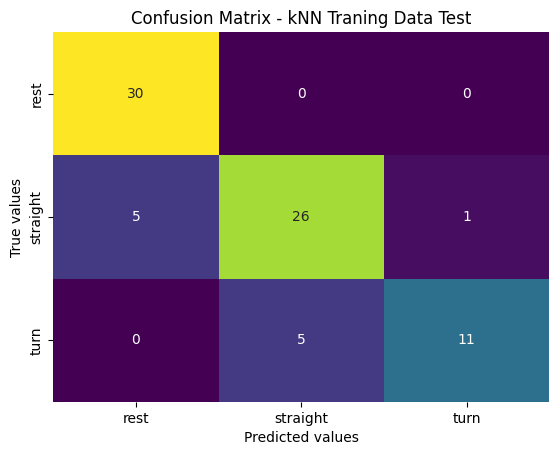


Classification Report for kNN Traning Data Test:
              precision    recall  f1-score   support

        rest       0.86      1.00      0.92        30
    straight       0.84      0.81      0.83        32
        turn       0.92      0.69      0.79        16

    accuracy                           0.86        78
   macro avg       0.87      0.83      0.84        78
weighted avg       0.86      0.86      0.85        78


Accuracy Score: 0.8589743589743589
Precision Score: 0.8708397337429595
Recall Score: 0.8333333333333334
F1 Score: 0.8447293447293447


In [461]:
evaluate_classification(y_test, grid.predict(X_test), ['rest', 'straight','turn'], 'kNN Traning Data Test')

In [462]:
# evaluate_classification(y2, grid.predict(X2), ['rest', 'straight','turn'], 'kNN Test Data 1')

In [463]:
# evaluate_classification(y3, grid.predict(X3), ['rest', 'straight','turn'], 'kNN Test Data 2')